# <center> Bayesian Network: a probabilistic model for lung cancer prediction </center>
<center> Project for the third module of "Fundamentals of Artificial Intelligence and Knowledge Representation" </center>
<h4> <center>  Lorenzo Pellegrino - <a href="lorenzo.pellegrino2@studio.unibo.it"> lorenzo.pellegrino2@studio.unibo.it </a>  </center> </h4>

# Abstract
Scrivi ..

# Index
1. [**Imports**](#Imports)
    
2. [**Data Exploration**](#Data-Exploration)

    2.1 [Import dataset](#import-dataset)

    2.2 [Attributes and their types](#attributes-and-their-types)

    2.3 [Description of the dataset](#description-of-the-dataset)

    2.4 [Distributions of the dataset](#distributions-in-the-datasets) 

3. [**Preprocessing**](#Preprocessing)

    3.1 [Age](#group-ages-kmeans)

    3.2 [Level](#encode-level)

    3.3 [Correlation](#correlation)

    3.4 [Possible values](#possible-values)

4. [**Bayesian Network**](#bayesian-network)

    4.1 [Model](#model)

    - 4.1.1 [Custom Model](#custom-model)

    - 4.1.2 [Tree Model](#tree-model)
    
    - 4.1.3 [HillClimb Model](#hillclimb-model)

    4.2 [Graphs](#graph-plots)

    4.3 [Inference](#model)

    - 4.3.1 [Experiment functions](#experiment-functions)

    - 4.3.2 [Query 1](#query-1)
    
    - 4.3.3 [Query 2](#query-2)

# Imports

In [23]:
%load_ext autoreload
%autoreload 2

import warnings 
warnings.filterwarnings("ignore", category=UserWarning, module="pgmpy")
warnings.filterwarnings("ignore", category=FutureWarning, module="pgmpy")

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from utils import find_clusters, plot_distribution_cluster, print_full

from pgmpy.models import BayesianNetwork, NaiveBayes
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, TreeSearch, BDeuScore, K2Score, TreeSearch, BicScore, ParameterEstimator, BayesianEstimator, ExpectationMaximization

from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination, BeliefPropagation
from pgmpy.sampling import BayesianModelSampling, GibbsSampling
from pgmpy.factors.discrete import State
import networkx as nx
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Exploration

### Import dataset

In [24]:
df = pd.read_csv('./cancer.csv')
print(f'Dimension: {df.shape}')
print(f'Null values: {df.isna().sum().sum()}')

Dimension: (1000, 26)
Null values: 0


In [25]:
df

,index,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,Occupational Hazards,Genetic Risk,Chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
3,3,P1000,37,1,7,7,7,7,6,7,...,4,2,3,1,4,5,6,7,5,High
4,4,P101,46,1,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,P995,44,1,6,7,7,7,7,6,...,5,3,2,7,8,2,4,5,3,High
996,996,P996,37,2,6,8,7,7,7,6,...,9,6,5,7,2,4,3,1,4,High
997,997,P997,25,2,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
998,998,P998,18,2,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High


### Attributes and their types

In [26]:
df.dtypes

index                        int64
Patient Id                  object
Age                          int64
Gender                       int64
Air Pollution                int64
Alcohol use                  int64
Dust Allergy                 int64
Occupational Hazards         int64
Genetic Risk                 int64
Chronic Lung Disease         int64
Balanced Diet                int64
Obesity                      int64
Smoking                      int64
Passive Smoker               int64
Chest Pain                   int64
Coughing of Blood            int64
Fatigue                      int64
Weight Loss                  int64
Shortness of Breath          int64
Wheezing                     int64
Swallowing Difficulty        int64
Clubbing of Finger Nails     int64
Frequent Cold                int64
Dry Cough                    int64
Snoring                      int64
Level                       object
dtype: object

### Description of the dataset

- **Age**: The age of the patient. (Numeric)

- **Gender**: The gender of the patient. (Categorical)

- **Air Pollution**: The level of air pollution exposure of the patient. (Categorical)

- **Alcohol use**: The level of alcohol use of the patient. (Categorical)

- **Dust Allergy**: The level of dust allergy of the patient. (Categorical)

- **OccuPational Hazards**: The level of occupational hazards of the patient. (Categorical)

- **Genetic Risk**: The level of genetic risk of the patient. (Categorical)

- **Chronic Lung Disease**: The level of chronic lung disease of the patient. (Categorical)

- **Balanced Diet**: The level of balanced diet of the patient. (Categorical)

- **Obesity**: The level of obesity of the patient. (Categorical)

- **Smoking**: The level of smoking of the patient. (Categorical)

- **Passive Smoker**: The level of passive smoker of the patient. (Categorical)

- **Chest Pain**: The level of chest pain of the patient. (Categorical)

- **Coughing of Blood**: The level of coughing of blood of the patient. (Categorical)

- **Fatigue**: The level of fatigue of the patient. (Categorical)

- **Weight Loss**: The level of weight loss of the patient. (Categorical)

- **Shortness of Breath**: The level of shortness of breath of the patient. (Categorical)

- **Wheezing**: The level of wheezing of the patient. (Categorical)

- **Swallowing Difficulty**: The level of swallowing difficulty of the patient. (Categorical)

- **Clubbing of Finger Nails**: The level of clubbing of finger nails of the patient. (Categorical)

- **Frequent Cold**: The frequency of cold. (Categorical)

- **Dry Cough**: The level of dry cough of the patient. (Categorical)

- **Snoring**: The level of snoring of the patient. (Categorical)

- **Level**: The stage of cancer from (`Low`, `Medium`, `High`). (Categorical)

### Distributions in the datasets

In [27]:
# Drop non-meaningful data
df.drop(labels=['index', 'Patient Id'], axis=1, inplace=True)

In [28]:
# # Analysis of attributes' distributions
# plt.figure(figsize=(20, 100))

# i = 1
# for attribute in df.columns :
#     plt.subplot(24, 2, i)
#     sns.boxplot(data=df, x=attribute, showfliers=True, showmeans=True)
#     plt.title(f'{attribute} boxplot')

#     plt.subplot(24, 2, i+1)
#     sns.histplot(df[attribute], bins=20, kde=True, color='skyblue')
#     plt.title(f'{attribute} histogram')

#     i += 2

# plt.subplots_adjust(hspace=0.5)
# plt.show()

# Preprocessing

### Group Ages (KMeans)

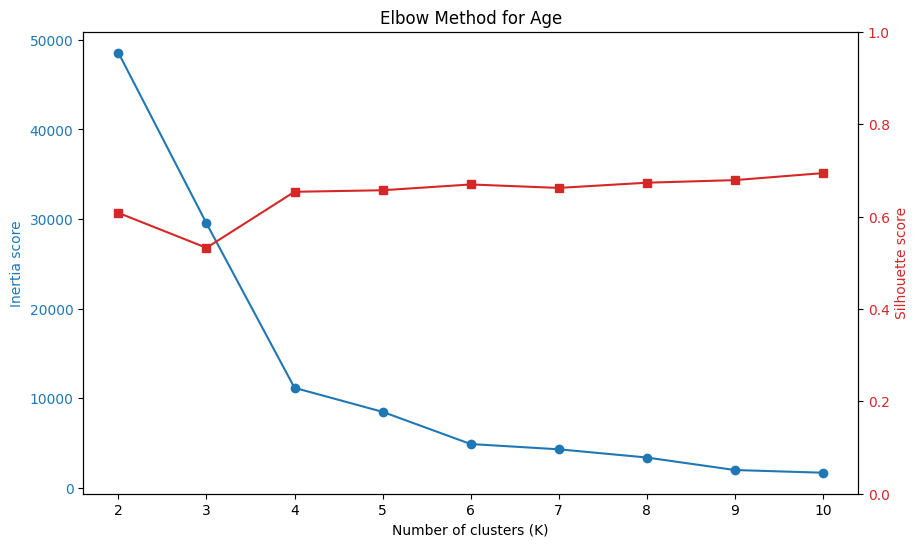

In [29]:
# Elbow method to choose the best clustering schema
find_clusters(df, 'Age')

There is an elbow in K=4 and in that point silhouette is quite high so we'll use 4 clusters.

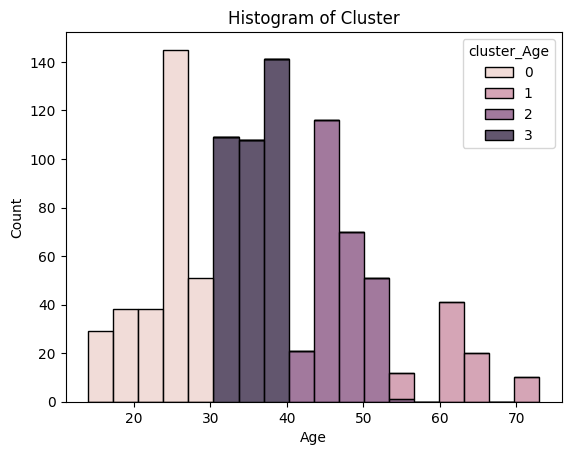

In [30]:
# We make 4 goups
plot_distribution_cluster(df, 'Age', 4)

In [31]:
# We have to clean the dataset
df.drop('Age', axis=1, inplace=True)
df.rename(columns={'cluster_Age': 'Age'}, inplace=True)
# Put Age at the beginning
df = df[['Age'] + df.columns.difference(['Age'], sort=False).tolist()]

### Encode attributes

In [32]:
# Encode attributes
le = LabelEncoder()
for c in df.columns[:-1] :
    df[c] = le.fit_transform(df[c])
le.fit(['Low', 'Medium', 'High'])
df['Level'] = df['Level'].map({'High': 2, 'Low': 0, 'Medium': 1})

### Correlation

<Axes: title={'center': 'Correlation plot'}>

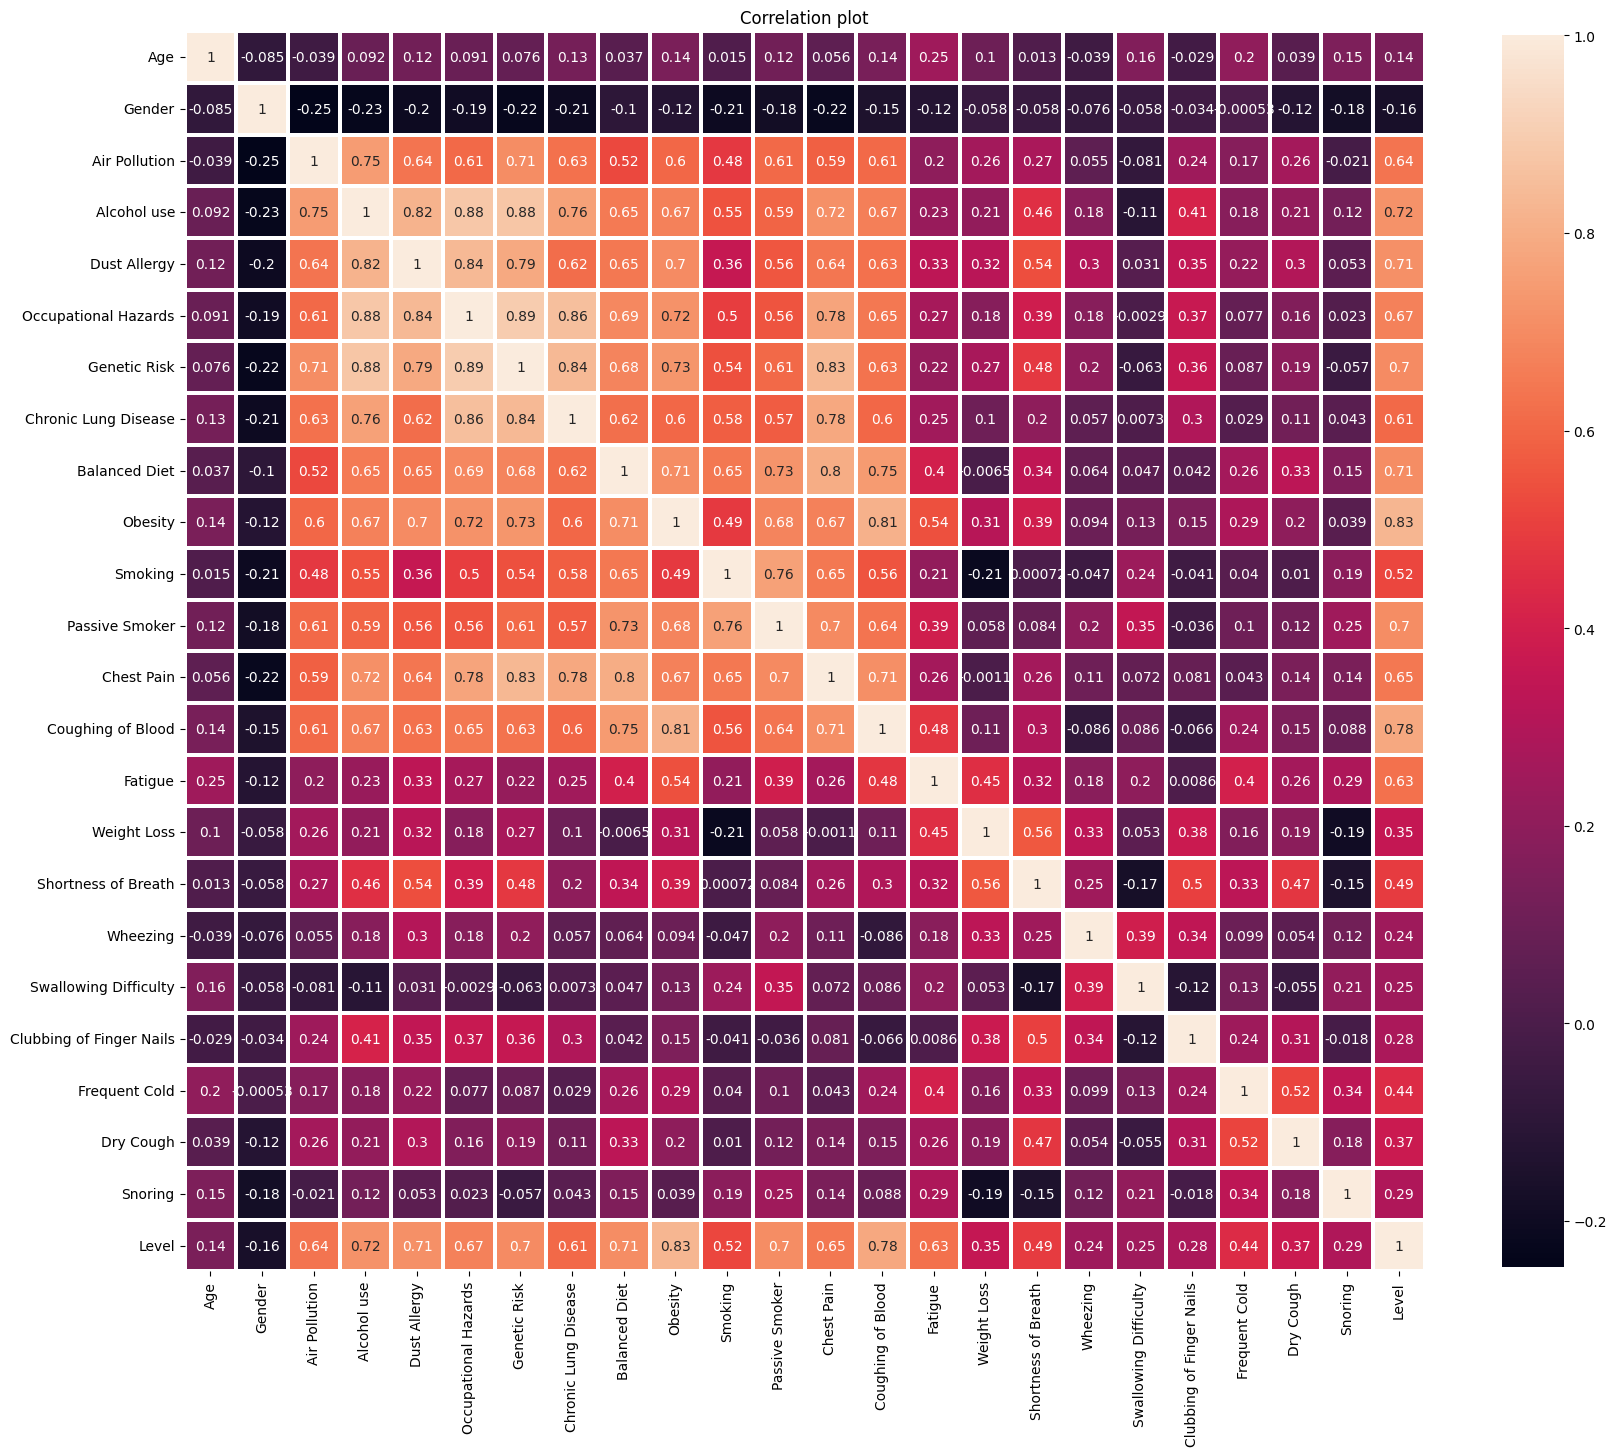

In [33]:
plt.figure(figsize=(20,20))
plt.title('Correlation plot')
sns.heatmap(df.corr(), 
            annot=True, 
            # cmap=sns.diverging_palette(230, 20, as_cmap=True),   
            square = True,                                 
            linewidths = 1.5,
            cbar_kws = {"shrink": .8})

We can notice that there are many attributes at the beginning which have a strong correlation among them and a strong (but negative) correlation to `Level`. 

There are others which have a much smaller correlaton with all the attributes, such as `Age`, `Gender`, `Snoring`, `Swallowing Difficulty`, `Snoring`, `Wheezing`, `Frequent Cold`, `Dry Cough`

In [34]:
# Remove the less correlated data to simplify the model
# df_lighter = df.drop(labels=['Age', 'Gender', 'Snoring', 'Swallowing Difficulty', 'Snoring', 'Wheezing', 'Frequent Cold', 'Dry Cough'], axis=1)
df_lighter = df.drop(labels=[
    'Gender', 
    'Snoring', 
    'Swallowing Difficulty', 
    'Snoring', 
    'Wheezing', 
    'Frequent Cold', 
    'Dry Cough',
    # New elinations
    'Dust Allergy',
    'Occupational Hazards', 
    'Balanced Diet', 
    # 'Obesity',
    'Clubbing of Finger Nails',
    'Weight Loss',
    'Fatigue',
    # 'Passive Smoker',
    'Shortness of Breath'
], axis=1)

<Axes: title={'center': 'Correlation plot'}>

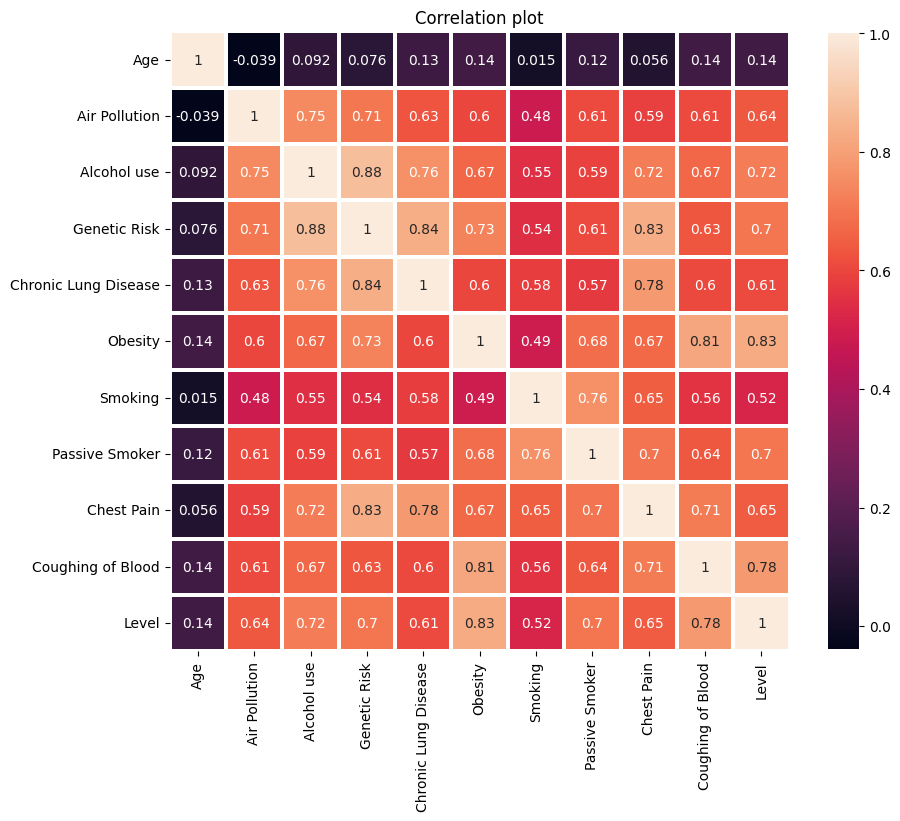

In [35]:
plt.figure(figsize=(10,10))
plt.title('Correlation plot')
sns.heatmap(df_lighter.corr(), 
            annot=True, 
            # cmap=sns.diverging_palette(230, 20, as_cmap=True),   
            square = True,                                 
            linewidths = 1.5,
            cbar_kws = {"shrink": .8})

### Possible values

In [36]:
possible_values = {c : np.sort(df_lighter[c].unique().tolist()) for c in df_lighter.columns}
possible_values
# {attr : max(possible_values[attr]) for attr in list(possible_values.keys())}

{'Age': array([0, 1, 2, 3]),
 'Air Pollution': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'Alcohol use': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'Genetic Risk': array([0, 1, 2, 3, 4, 5, 6]),
 'Chronic Lung Disease': array([0, 1, 2, 3, 4, 5, 6]),
 'Obesity': array([0, 1, 2, 3, 4, 5, 6]),
 'Smoking': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'Passive Smoker': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'Chest Pain': array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 'Coughing of Blood': array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 'Level': array([0, 1, 2])}

# Bayesian Network

In [37]:
from sklearn.model_selection import train_test_split

def split_dataset_for_bayesian_network(df, target_label, train_size):
    """
    Split the dataset into a combined X_train and y_train, and X_test, y_test.

    Parameters:
    - df: DataFrame, the dataset.
    - target_label: str, the label of the target variable.
    - train_size: float, the proportion of the dataset to include in the train split.

    Returns:
    - X_train_combined: DataFrame, the combined training features and target variable.
    - X_test: DataFrame, the testing features.
    - y_test: Series, the testing target variable.
    """
    # Extract features (X) and target variable (y)
    X = df.drop(columns=[target_label])
    y = df[target_label]

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

    # Combine X_train and y_train
    X_train_combined = X_train.copy()
    X_train_combined[target_label] = y_train

    return X_train_combined, X_test, y_test

In [38]:
# Maybe change name later
df_lighter, X_test, y_test = split_dataset_for_bayesian_network(df=df_lighter, target_label='Level', train_size=0.50)

df_lighter.shape, X_test.shape, y_test.shape

((500, 11), (500, 10), (500,))

## Models

In [39]:
models = {}

#### Custom Model

In [40]:
# We build the model considering 
custom_model = BayesianNetwork([
    # Causes 
    ('Smoking', 'Level'),
    ('Passive Smoker', 'Level'),
    ('Air Pollution', 'Level'),
    # ('Occupational Hazards', 'Level'),
    ('Genetic Risk', 'Level'),    
    ('Chronic Lung Disease', 'Level'),
    ('Alcohol use', 'Level'),
    ('Age', 'Level'), # ?
    
    # Consequences
    ('Level', 'Coughing of Blood'),
    # ('Level', 'Shortness of Breath'),
    ('Level', 'Chest Pain'),
    # ('Level', 'Weight Loss'),
    # ('Level', 'Fatigue'),
    # ('Level', 'Clubbing of Finger Nails'),

    # Other influences
    ('Alcohol use', 'Obesity'),
    # ('Balanced Diet', 'Obesity'),
    # ('Shortness of Breath', 'Clubbing of Finger Nails'), # ?
    # ('Shortness of Breath', 'Fatigue'),
    # ('Dust Allergy', 'Shortness of Breath'),
    ('Age', 'Chronic Lung Disease') # ?
])

custom_model.cdps = []
custom_model.fit(data=df_lighter, estimator=MaximumLikelihoodEstimator)

models['Custom'] = custom_model

#### Tree Model

In [41]:
ts = TreeSearch(data=df_lighter, root_node='Level')
tree_model = ts.estimate(show_progress=False)

tree_model = BayesianNetwork(tree_model.edges())

estimator = MaximumLikelihoodEstimator(tree_model, df_lighter)
cpds = estimator.get_parameters()
tree_model.add_cpds(*cpds)

models['Tree'] = tree_model

In [42]:
# Print all the learned CPTs
for cpd in tree_model.get_cpds() : print_full(cpd)

+----------+-------+
| Level(0) | 0.294 |
+----------+-------+
| Level(1) | 0.352 |
+----------+-------+
| Level(2) | 0.354 |
+----------+-------+
+-------------------+----------------------+---------------------+---------------------+
| Level             | Level(0)             | Level(1)            | Level(2)            |
+-------------------+----------------------+---------------------+---------------------+
| Passive Smoker(0) | 0.19727891156462585  | 0.0                 | 0.0                 |
+-------------------+----------------------+---------------------+---------------------+
| Passive Smoker(1) | 0.41496598639455784  | 0.5170454545454546  | 0.0                 |
+-------------------+----------------------+---------------------+---------------------+
| Passive Smoker(2) | 0.09523809523809523  | 0.09659090909090909 | 0.192090395480226   |
+-------------------+----------------------+---------------------+---------------------+
| Passive Smoker(3) | 0.19727891156462585  | 0.28977

In [43]:
for i in df_lighter.columns:
    print("Markov Blanket of the node" + str(i) + ":")
    print(tree_model.get_markov_blanket(i))
    print("------")

Markov Blanket of the nodeAge:
['Air Pollution']
------
Markov Blanket of the nodeAir Pollution:
['Alcohol use', 'Age']
------
Markov Blanket of the nodeAlcohol use:
['Coughing of Blood', 'Air Pollution', 'Passive Smoker', 'Chest Pain', 'Smoking']
------
Markov Blanket of the nodeGenetic Risk:
['Coughing of Blood', 'Chronic Lung Disease']
------
Markov Blanket of the nodeChronic Lung Disease:
['Genetic Risk']
------
Markov Blanket of the nodeObesity:
['Coughing of Blood']
------
Markov Blanket of the nodeSmoking:
['Alcohol use']
------
Markov Blanket of the nodePassive Smoker:
['Level', 'Alcohol use']
------
Markov Blanket of the nodeChest Pain:
['Alcohol use']
------
Markov Blanket of the nodeCoughing of Blood:
['Alcohol use', 'Obesity', 'Genetic Risk']
------
Markov Blanket of the nodeLevel:
['Passive Smoker']
------


#### HillClimb Model

In [44]:
# Bayesian Dirichlet equivalent uniform
scorer = BDeuScore(data=df_lighter)
hc = HillClimbSearch(data=df_lighter)
hc_base_model_bdeu = BayesianNetwork(hc.estimate(scoring_method=scorer, show_progress=False).edges())

estimator = MaximumLikelihoodEstimator(hc_base_model_bdeu, df_lighter)
cpds = estimator.get_parameters()
hc_base_model_bdeu.add_cpds(*cpds)

models['HillClimb_BDeu'] = hc_base_model_bdeu

#### HillClimb Model

### Graph plots

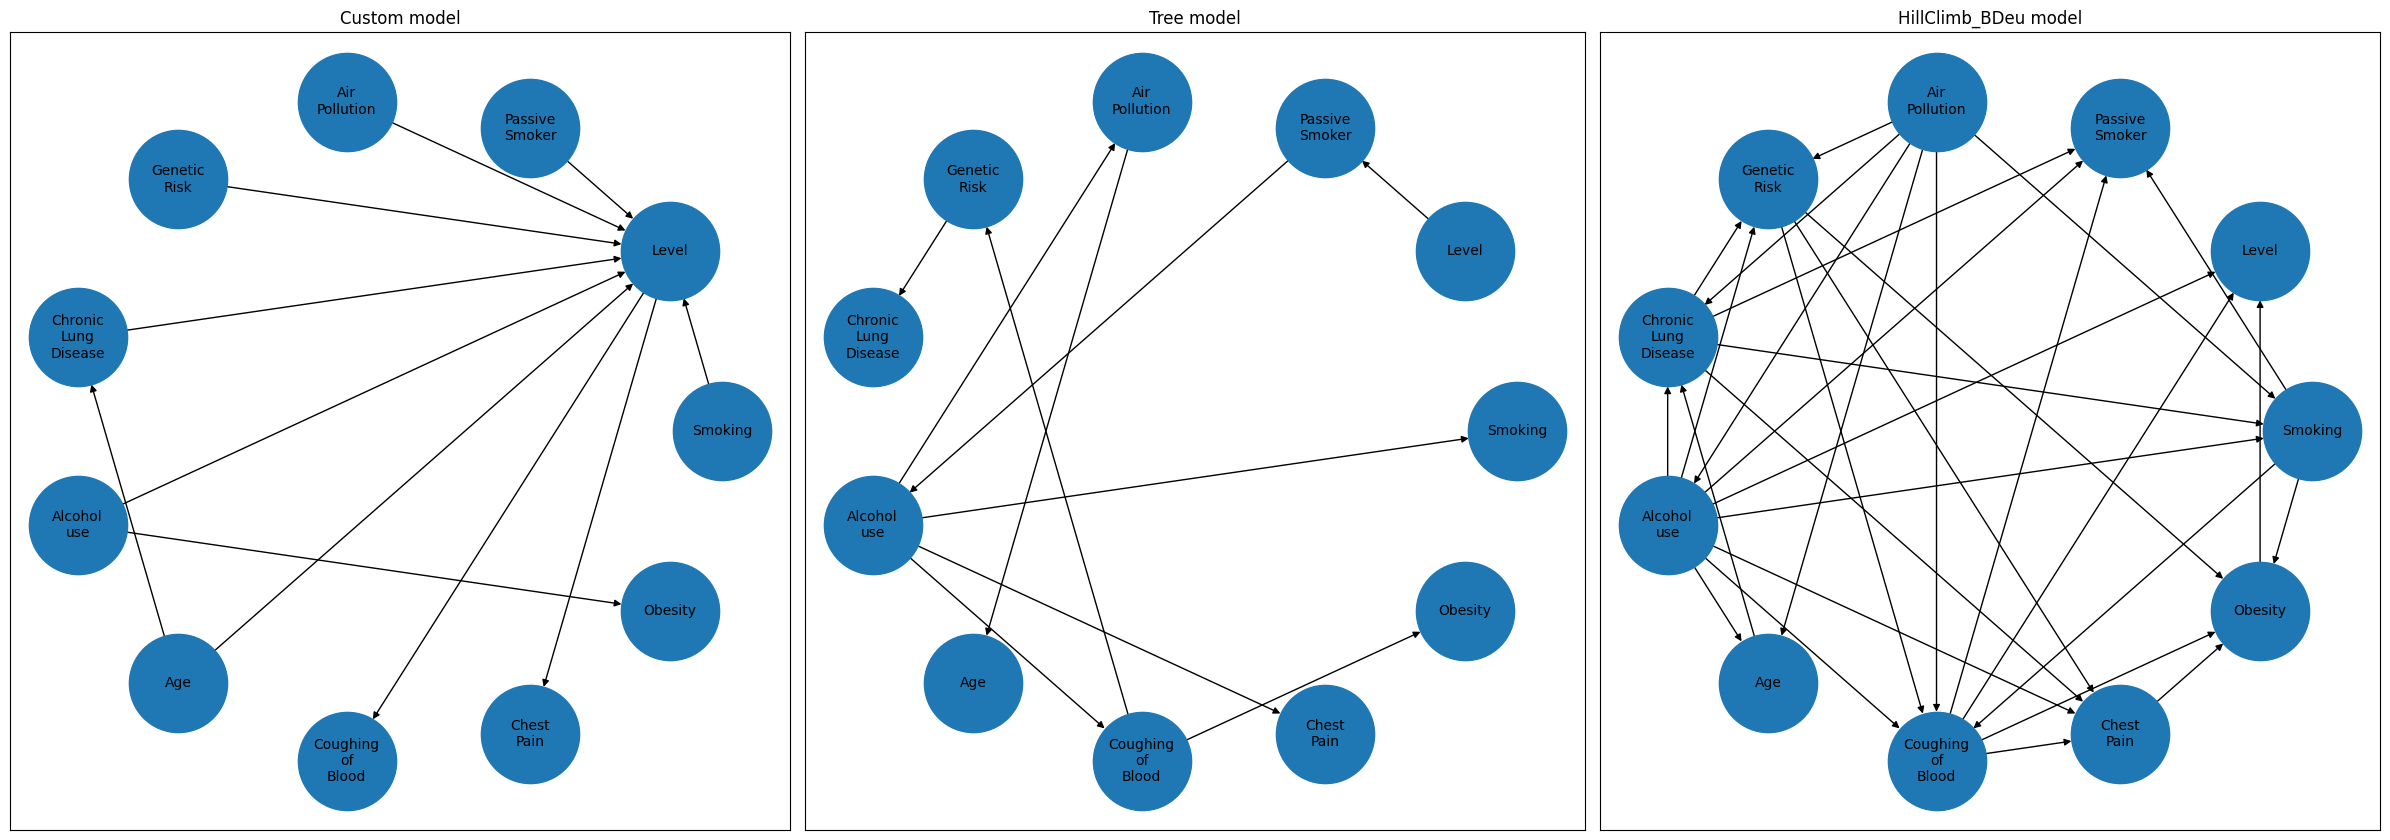

In [45]:
first_model_name = list(models.keys())[0]
layout = nx.drawing.layout.circular_layout(models[first_model_name])

fig, axes = plt.subplots(1, 3, figsize=(24, 8.5))
 
for i, (m, ax) in enumerate(zip(models.keys(), axes.flatten())):
    # Ensure all nodes in the model are present in the layout
    nx.draw_networkx(models[m], pos=layout, ax=ax, node_size=5000, with_labels=False)
    
    # Draw node labels with line breaks
    labels = {k: '\n'.join(k.split()) for k in models[m].nodes()}  # Replace spaces with line breaks
    nx.draw_networkx_labels(models[m], pos=layout, labels=labels, ax=ax, font_size=10)
    
    ax.set_title(f'{m} model')

plt.tight_layout()
plt.show()

We can make some observations about the models we obtained:
- `Custom model` : We have the `Level` as the 'center' of our model as it is influenced by causes and produces consequences, as we expected.

- `Tree model` : We have the `Alcohol use` as the root node which does not really make sense and we can see that also other nodes have strange relations. Then is intresting to notice the very few relations of Level, very far away from what we expecetd.

- `HillClimb model` : We got an highly unreadable graph where the attributes are quite interconnected between each other and it's difficult to identify a central attribute. Giving a look to some relations we can still see some meaningless ones. We could prevent this by injecting some prior knowledge to delete some strange links, but we'll continue in this way in order to test the complexity of those nested relations (even because we already used it in te Custom Model)

## Inference

### Experiment functions

In [46]:
def inspect_multi_dim_array(values, comb) :
    i = 0
    while values.shape != () :
        values = values[comb[i]]
        i += 1
    return values


def exact_inference(query, evidence, model):
    """
    Perform exact inference using Variable Elimination in pgmpy.

    Parameters:
    - query (list or str): Variables for which to compute the posterior distribution.
    - evidence (dict): Evidence as a dictionary where keys are variables and values are observed values.
    - model (BayesianNetwork): The Bayesian model.

    Returns:
    - result: The result of the inference query.
    """
    inference = VariableElimination(model)
    result = inference.query(variables=query, evidence=evidence)

    labels = query + ["P({})".format(", ".join(query))]
    query_combinations = list(itertools.product(*[df_lighter[var].unique() for var in query]))
    sorted_combinations = sorted(query_combinations, key=lambda x: tuple(x))

    rows = []
    for comb in sorted_combinations :
        rows.append(comb + (round(inspect_multi_dim_array(result.values, comb),3),)) # round to 3 to be comparable with approximate_inference

    return pd.DataFrame(rows, columns=labels)

In [47]:
def approximate_inference(query, evidence, model, num_samples=1000):
    """
    Perform approximate inference using BayesianModelSampling in pgmpy with rejection sampling.

    Parameters:
    - query (list or str): Variables for which to compute the posterior distribution.
    - evidence (dict): Evidence as a list of `pgmpy.factors.discrete.State`(variables, values) that are observed.
    - model (BayesianModel): The Bayesian model.
    - num_samples (int): Number of samples to generate.

    Returns:
    - result: The result of the inference query.
    """
    sampling_model = BayesianModelSampling(model)
    samples = sampling_model.rejection_sample(evidence=evidence, size=num_samples, show_progress=False, seed=42) #NOTE: likelihood_weighted_sample(evidence = evidence, size=num_samples) gives index errors
    samples.drop(columns=samples.columns.difference(query), inplace=True)

    # Inizialize the result
    labels = query + ["P({})".format(", ".join(query))]
    result = pd.DataFrame(columns=labels)

    # Insert the rows
    query_combinations = list(itertools.product(*[samples[var].unique() for var in query]))
    sorted_combinations = sorted(query_combinations, key=lambda x: tuple(x))
    for comb in sorted_combinations:
        probability = round(len(samples[samples[query].eq(comb).all(axis=1)]) / len(samples), 50)
        result.loc[len(result)] = comb + (probability,)

    result.iloc[:, :-1] = result.iloc[:, :-1].astype('int64')

    return result

In [48]:
def error_computer(table_exact, table_approx):
    """
    Compute the mean relative and absolute errors between exact and approximate probability tables.

    Parameters:
    - table_exact (pd.DataFrame): A DataFrame representing the exact probability table.
    - table_approx (pd.DataFrame): A DataFrame representing the approximate probability table.

    Returns:
    - mean_relative_error (float): The mean relative error between exact and approximate values.
    - mean_absolute_error (float): The mean absolute error between exact and approximate values.

    Example:
    >>> table_exact = pd.DataFrame({'A': [1, 2, 3], 'B': [0.2, 0.5, 0.3], 'Probability': [0.1, 0.4, 0.5]})
    >>> table_approx = pd.DataFrame({'A': [1, 2, 3], 'B': [0.25, 0.45, 0.3], 'Probability': [0.12, 0.38, 0.5]})
    >>> mean_rel_err, mean_abs_err = error_computer(table_exact, table_approx)
    >>> print(mean_rel_err)
    0.023333333333333334
    >>> print(mean_abs_err)
    0.021666666666666667
    """
    # Extract the last column (Probability) from both tables
    approximate = table_approx.iloc[:, -1]
    exact = table_exact.iloc[:, -1]

    # Compute the mean relative error
    mean_relative_error = np.mean(np.abs((exact - approximate) / exact))

    # Compute the mean absolute error
    mean_absolute_error = np.mean(np.abs((exact - approximate)))

    return (mean_relative_error, mean_absolute_error)


In [49]:
def plot_error(result):
    """
    Plot the relative and absolute errors over the course of an experiment.

    Parameters:
    - result (dict): A dictionary containing errors obtained from an experiment.

    Returns:
    - None: Displays a plot of relative and absolute errors over the experiment.

    Example:
    >>> result = {'Custom': {'errors': {...}}}
    >>> plot_error(result)
    """
    # Extracting data from the result dictionary
    samples = list(result['errors'].keys())
    relative_errors, absolute_errors = zip(*result['errors'].values())

    # Creating a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plotting relative errors
    axs[0].semilogx(samples, relative_errors)
    axs[0].set_title('Relative error over the experiment')
    axs[0].set_xlabel('Number of samples')
    axs[0].set_ylabel('Relative error (%)')

    # Plotting absolute errors
    axs[1].semilogx(samples, absolute_errors)
    axs[1].set_title('Absolute error over the experiment')
    axs[1].set_xlabel('Number of samples')
    axs[1].set_ylabel('Absolute error')

    # Adjusting layout to prevent clipping of titles
    plt.tight_layout()

    # Displaying the plot
    plt.show()


In [50]:
def generate_probability_string(variables, values, evidence_dict):
    """
    Generate a probability string in the format P(variable_1=value_1, variable_2=value_2, ... | evidence_1=value_1, evidence_2=value_2, ...).

    Parameters:
    - variables (list): A list of variable names for which the probability is being calculated.
    - values (list): A list of corresponding values for the variables.
    - evidence_dict (dict): A dictionary representing the evidence for the probability calculation.

    Returns:
    - probability_string (str): A formatted probability string.
    
    Example:
    >>> variables = ['A', 'B', 'C']
    >>> values = [1, 3, 5]
    >>> evidence_dict = {'ev1': 1, 'ev2': 2}
    >>> generate_probability_string(variables, values, evidence_dict)
    'P(A=1, B=3, C=5 | ev1=1, ev2=2)'
    """
    probability_string = 'P'

    # Create a dictionary of variable names and values
    variable_values = {var: val for var, val in zip(variables, values)}

    # Create a list of evidence values
    evidence_values = [f'{key}={value}' for key, value in evidence_dict.items()]

    # Format the probability string
    probability_string += f'({", ".join([f"{var}={round(val)}" for var, val in variable_values.items()])}'

    if evidence_values:
        probability_string += f' | {", ".join(evidence_values)})'

    return probability_string


In [51]:
def plot_probabilities(result, evidence, query, index):
    """
    Plot the probabilities obtained from approximate and exact calculations against the number of samples.

    Parameters:
    - result (dict): A dictionary containing exact and approximate probability tables.
    - evidence (dict): A dictionary representing the evidence for the probability calculation.
    - query (list): A list of variable names for which the probability is being calculated.

    Returns:
    - None: Displays a plot of approximate and exact values.

    Example:
    >>> evidence = {'ev1': 1, 'ev2': 2}
    >>> query = ['A', 'B', 'C']
    >>> result = {'Custom': {'exact': pd.DataFrame(...), 'approximatives': {...}}}
    >>> plot_probabilities(result, evidence, query)
    """
    # Select a random row to analyze
    # index = random.randint(0, (min([table.shape[0]-1 for table in result['approximatives'].values()])))
    
    # Get exact and approximate values for the selected row
    exact_value = result['exact'].iloc[index][-1]
    approximate_values = [table.iloc[index][-1] for table in result['approximatives'].values()]
    samples = list(result['approximatives'].keys())

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.semilogx(samples, approximate_values, label='Approximate Value')
    plt.axhline(y=exact_value, color='r', linestyle='--', label=f'Exact Value ({exact_value})')
    plt.xlabel('Number of samples')
    plt.ylabel(result['exact'].columns[-1])
    plt.title(generate_probability_string(variables=query, values=result['exact'].iloc[index][:-1], evidence_dict=evidence))
    plt.legend()
    plt.show()


In [52]:
def experiment(query, evidence, models):
    """
    Perform a probabilistic inference experiment on a set of Bayesian models.

    Parameters:
    - query (list or str): Variables for which to compute the posterior distribution.
    - evidence (dict): Evidence as a dictionary where keys are variables and values are observed values.
    - models (dict): Dictionary of Bayesian models, where keys are model names and values are BayesianModel instances.

    Returns:
    - results (dict): Dictionary containing the results of the experiment for each model.
        - For each model:
            - 'exact' (dict): Results of exact inference using Variable Elimination and Belief Propagation.
            - 'approximate' (dict): Results of approximate inference using Rejection Sampling.
    """
    results = {}

    evidence_transformed = [State(m,s) for m,s in evidence.items()] # we convert it for `rejection_sample`

    index = 0 # for comparing the same probability among all models
    for m in models.keys():
        # if m == 'Custom' : # semlification for our experiment but can be extended with many models
        print(20*'#' + f" Comuting experiment for {m} Model " + 50*'#')

        # Define containers
        approximatives = {}
        errors = {}

        # Collect approximative probabilities
        for size in np.logspace(1, 5, num=20, dtype='<i8') :
            approximatives[size] = approximate_inference(query, evidence_transformed, models[m], num_samples=size)
        
        # Collect the probabilities
        results[m] = {
            'exact': exact_inference(query, evidence, models[m]),
            'approximatives': approximatives
        }

        # Compute the erros
        for samples,tabel in results[m]['approximatives'].items() :
            errors[samples] = error_computer(table_exact=results[m]['exact'], table_approx=tabel)
        results[m]['errors'] = errors

        # Plots
        plot_error(results[m])
        plot_probabilities(results[m], evidence=evidence, query=query, index=index)
    
    return results

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from pgmpy.inference.ExactInference import BeliefPropagation
from pgmpy.inference.CausalInference import CausalInference

def test(X_test, y_test, model):
    """
    Evaluate a Bayesian Network model on the test set and calculate various performance metrics.

    Parameters:
    - X_test: DataFrame, the testing features.
    - y_test: Series, the true testing target variable.
    - model: BayesianNetwork, the trained Bayesian Network model.

    Returns:
    - accuracy: float, accuracy of the model.
    - precision: float, precision of the model.
    - recall: float, recall of the model.
    - f1: float, F1-score of the model.
    - confusion_mat: array, confusion matrix.
    """

    # Get predictions for each instance in X_test
    predictions = {
        'variable_elimination' : [],
        'belief_propagation' : [],
        'causal_inference' : [],
        # 'gibbs_sampling' : [],
    }

    # Inferences
    variable_elimination = VariableElimination(model)
    belief_propagation = BeliefPropagation(model)
    causal_inference = CausalInference(model)
    # bayesian_sample = BayesianModelSampling(model) # ?
    # gibbs_sampling = GibbsSampling(model)


    # Performances
    accuracy = {}
    precision = {}
    recall = {}
    f1 = {}
    confusion_mat = {}
    roc_auc = {}

    for i,(_ ,instance) in enumerate(X_test.iterrows()):
        ####################################################################################################
        ### Exact inference ################################################################################
        ####################################################################################################
        # 1) VariableElimination
        predictions['variable_elimination'].append(variable_elimination.map_query(variables=['Level'], evidence=dict(instance), show_progress=False)['Level'])
        # 2) BeliefPropagation
        predictions['belief_propagation'].append(belief_propagation.map_query(variables=['Level'], evidence=dict(instance), show_progress=False)['Level'])
        # 3) CausalInference
        predictions['causal_inference'].append(np.argmax(causal_inference.query(variables=['Level'], evidence=dict(instance), show_progress=False).values))

        # ####################################################################################################
        # ### Approximate inference ##########################################################################
        # ####################################################################################################
        # # 1) GibbsSampling (?)
        # predictions['gibbs_sampling'].append(gibbs_sampling.map_query(variables=['Level'], evidence=dict(instance), show_progress=False)['Level'])
        # # 2) Approx
        # print(ApproxInference(models['Custom']).query(variables=['Level'], evidence=dict(instance), show_progress=False)) 

        print(f"Done: {i}/{len(X_test)}")

    
    print(predictions)
    # Calculate performance metrics
    for infer_type in predictions.keys():
        accuracy[infer_type] = accuracy_score(y_test, predictions[infer_type])
        precision[infer_type] = precision_score(y_test, predictions[infer_type], average='weighted')  
        recall[infer_type] = recall_score(y_test, predictions[infer_type], average='weighted') 
        f1[infer_type] = f1_score(y_test, predictions[infer_type], average='weighted') 
        # roc_auc[infer_type] = roc_auc_score(y_test, predictions[infer_type], multi_class='ovr', average='weighted')
        confusion_mat[infer_type] = confusion_matrix(y_test, predictions[infer_type])

    result = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        # 'roc_auc': roc_auc,
        'confusion_mat': confusion_mat
    }

    return result

In [54]:
testing = {}
for m in models.keys() :
    print(m)
    testing[m] = test(X_test, y_test, models[m])

Custom


Done: 0/500
Done: 1/500
Done: 2/500
Done: 3/500
Done: 4/500
Done: 5/500
Done: 6/500
Done: 7/500
Done: 8/500
Done: 9/500
Done: 10/500
Done: 11/500
Done: 12/500
Done: 13/500
Done: 14/500
Done: 15/500
Done: 16/500
Done: 17/500
Done: 18/500
Done: 19/500
Done: 20/500
Done: 21/500
Done: 22/500
Done: 23/500
Done: 24/500
Done: 25/500
Done: 26/500
Done: 27/500
Done: 28/500
Done: 29/500
Done: 30/500
Done: 31/500
Done: 32/500
Done: 33/500
Done: 34/500
Done: 35/500
Done: 36/500
Done: 37/500
Done: 38/500
Done: 39/500
Done: 40/500
Done: 41/500
Done: 42/500
Done: 43/500
Done: 44/500
Done: 45/500
Done: 46/500
Done: 47/500
Done: 48/500
Done: 49/500
Done: 50/500
Done: 51/500
Done: 52/500
Done: 53/500
Done: 54/500
Done: 55/500
Done: 56/500
Done: 57/500
Done: 58/500
Done: 59/500
Done: 60/500
Done: 61/500
Done: 62/500
Done: 63/500
Done: 64/500
Done: 65/500
Done: 66/500
Done: 67/500
Done: 68/500
Done: 69/500
Done: 70/500
Done: 71/500
Done: 72/500
Done: 73/500
Done: 74/500
Done: 75/500
Done: 76/500
Done: 77/

/usr/local/lib/python3.12/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:491: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Done: 357/500
Done: 358/500
Done: 359/500
Done: 360/500
Done: 361/500
Done: 362/500
Done: 363/500
Done: 364/500
Done: 365/500
Done: 366/500
Done: 367/500
Done: 368/500
Done: 369/500
Done: 370/500
Done: 371/500
Done: 372/500
Done: 373/500
Done: 374/500
Done: 375/500
Done: 376/500
Done: 377/500
Done: 378/500
Done: 379/500
Done: 380/500
Done: 381/500
Done: 382/500
Done: 383/500
Done: 384/500
Done: 385/500
Done: 386/500
Done: 387/500
Done: 388/500
Done: 389/500
Done: 390/500
Done: 391/500
Done: 392/500
Done: 393/500
Done: 394/500
Done: 395/500
Done: 396/500
Done: 397/500
Done: 398/500
Done: 399/500
Done: 400/500
Done: 401/500
Done: 402/500
Done: 403/500
Done: 404/500
Done: 405/500
Done: 406/500
Done: 407/500
Done: 408/500
Done: 409/500
Done: 410/500
Done: 411/500
Done: 412/500
Done: 413/500
Done: 414/500
Done: 415/500
Done: 416/500
Done: 417/500
Done: 418/500
Done: 419/500
Done: 420/500
Done: 421/500
Done: 422/500
Done: 423/500
Done: 424/500
Done: 425/500
Done: 426/500
Done: 427/500
Done: 

/usr/local/lib/python3.12/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:799: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values


Done: 0/500
Done: 1/500
Done: 2/500
Done: 3/500
Done: 4/500
Done: 5/500
Done: 6/500
Done: 7/500
Done: 8/500
Done: 9/500
Done: 10/500
Done: 11/500
Done: 12/500
Done: 13/500
Done: 14/500
Done: 15/500
Done: 16/500
Done: 17/500
Done: 18/500
Done: 19/500
Done: 20/500
Done: 21/500
Done: 22/500
Done: 23/500
Done: 24/500
Done: 25/500
Done: 26/500
Done: 27/500
Done: 28/500
Done: 29/500
Done: 30/500
Done: 31/500
Done: 32/500
Done: 33/500
Done: 34/500
Done: 35/500
Done: 36/500
Done: 37/500
Done: 38/500
Done: 39/500
Done: 40/500
Done: 41/500
Done: 42/500
Done: 43/500
Done: 44/500
Done: 45/500
Done: 46/500
Done: 47/500
Done: 48/500
Done: 49/500
Done: 50/500
Done: 51/500
Done: 52/500
Done: 53/500
Done: 54/500
Done: 55/500
Done: 56/500
Done: 57/500
Done: 58/500
Done: 59/500
Done: 60/500
Done: 61/500
Done: 62/500
Done: 63/500
Done: 64/500
Done: 65/500
Done: 66/500
Done: 67/500
Done: 68/500
Done: 69/500
Done: 70/500
Done: 71/500
Done: 72/500
Done: 73/500
Done: 74/500
Done: 75/500
Done: 76/500
Done: 77/

/usr/local/lib/python3.12/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:491: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Done: 152/500
Done: 153/500
Done: 154/500
Done: 155/500
Done: 156/500
Done: 157/500
Done: 158/500
Done: 159/500
Done: 160/500
Done: 161/500
Done: 162/500
Done: 163/500
Done: 164/500
Done: 165/500
Done: 166/500
Done: 167/500
Done: 168/500
Done: 169/500
Done: 170/500
Done: 171/500
Done: 172/500
Done: 173/500
Done: 174/500
Done: 175/500
Done: 176/500
Done: 177/500
Done: 178/500
Done: 179/500
Done: 180/500
Done: 181/500
Done: 182/500
Done: 183/500
Done: 184/500
Done: 185/500
Done: 186/500
Done: 187/500
Done: 188/500
Done: 189/500
Done: 190/500
Done: 191/500
Done: 192/500
Done: 193/500
Done: 194/500
Done: 195/500
Done: 196/500
Done: 197/500
Done: 198/500
Done: 199/500
Done: 200/500
Done: 201/500
Done: 202/500
Done: 203/500
Done: 204/500
Done: 205/500
Done: 206/500
Done: 207/500
Done: 208/500
Done: 209/500
Done: 210/500
Done: 211/500
Done: 212/500
Done: 213/500
Done: 214/500
Done: 215/500
Done: 216/500
Done: 217/500
Done: 218/500
Done: 219/500
Done: 220/500
Done: 221/500
Done: 222/500
Done: 

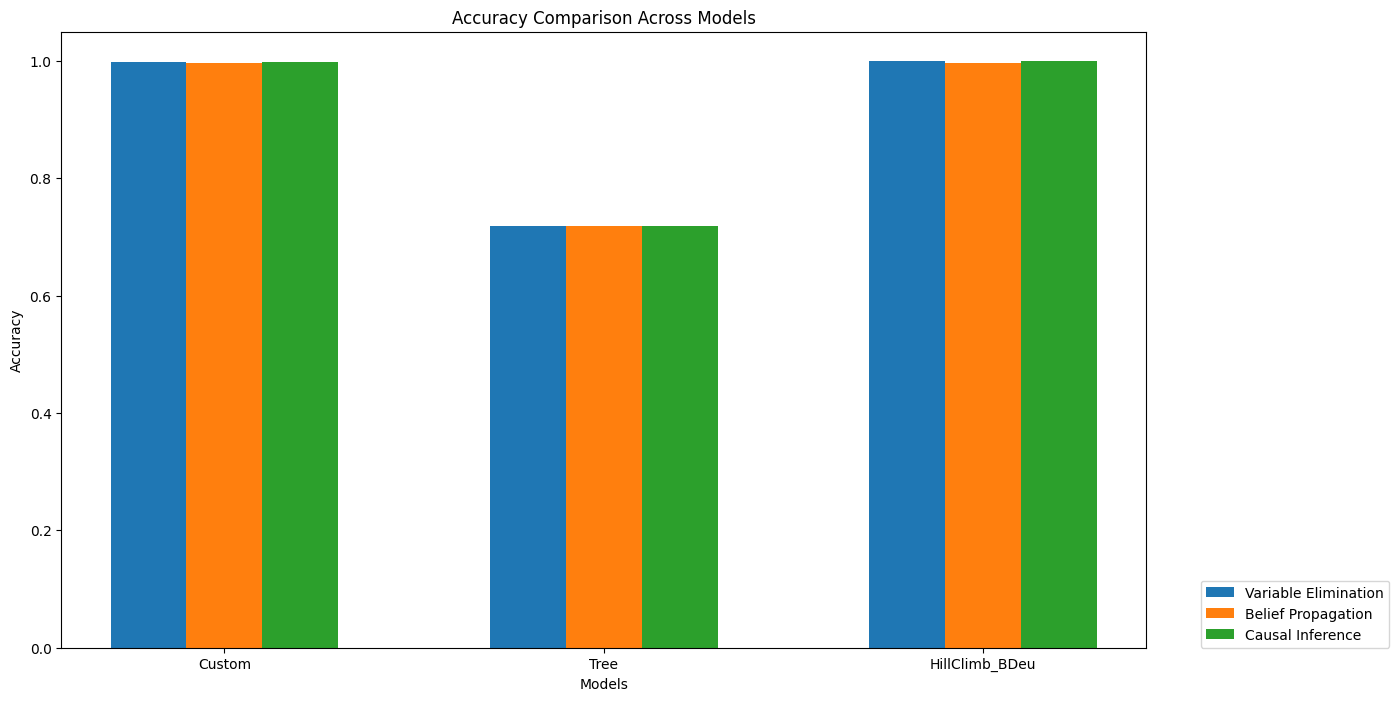

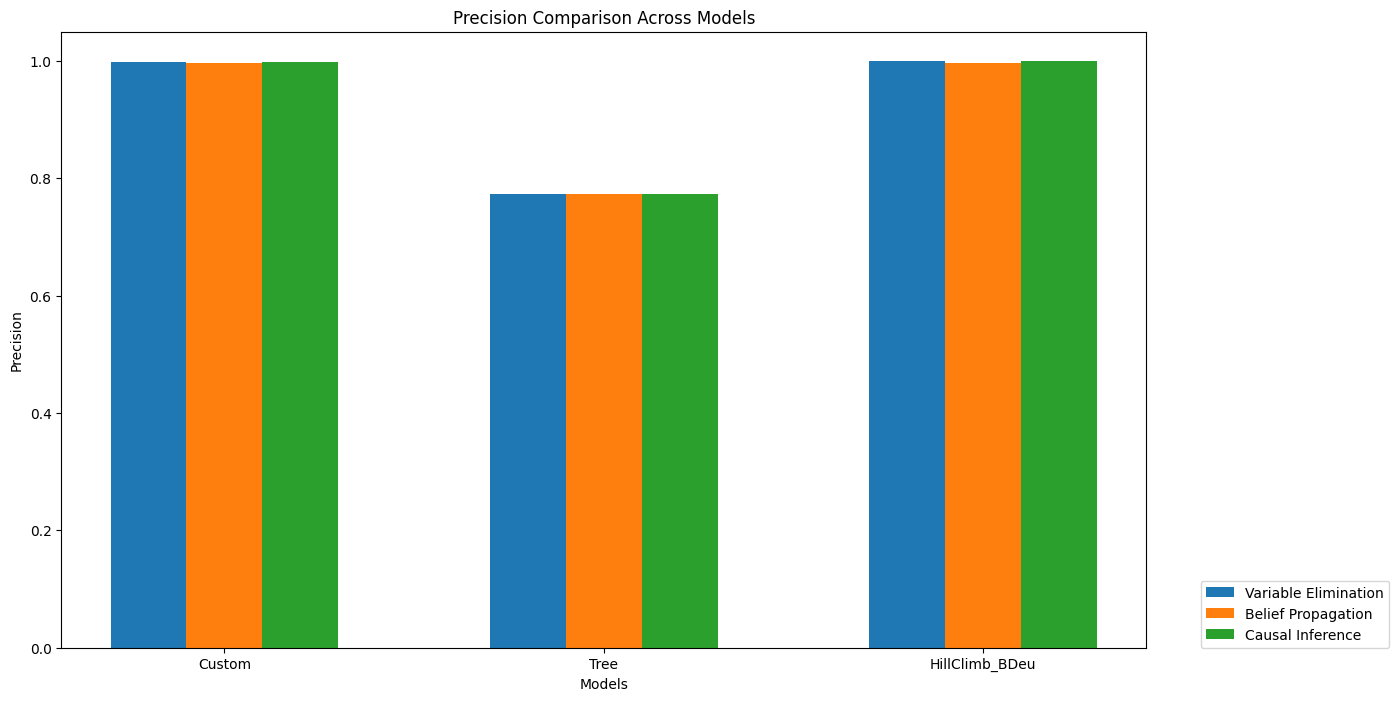

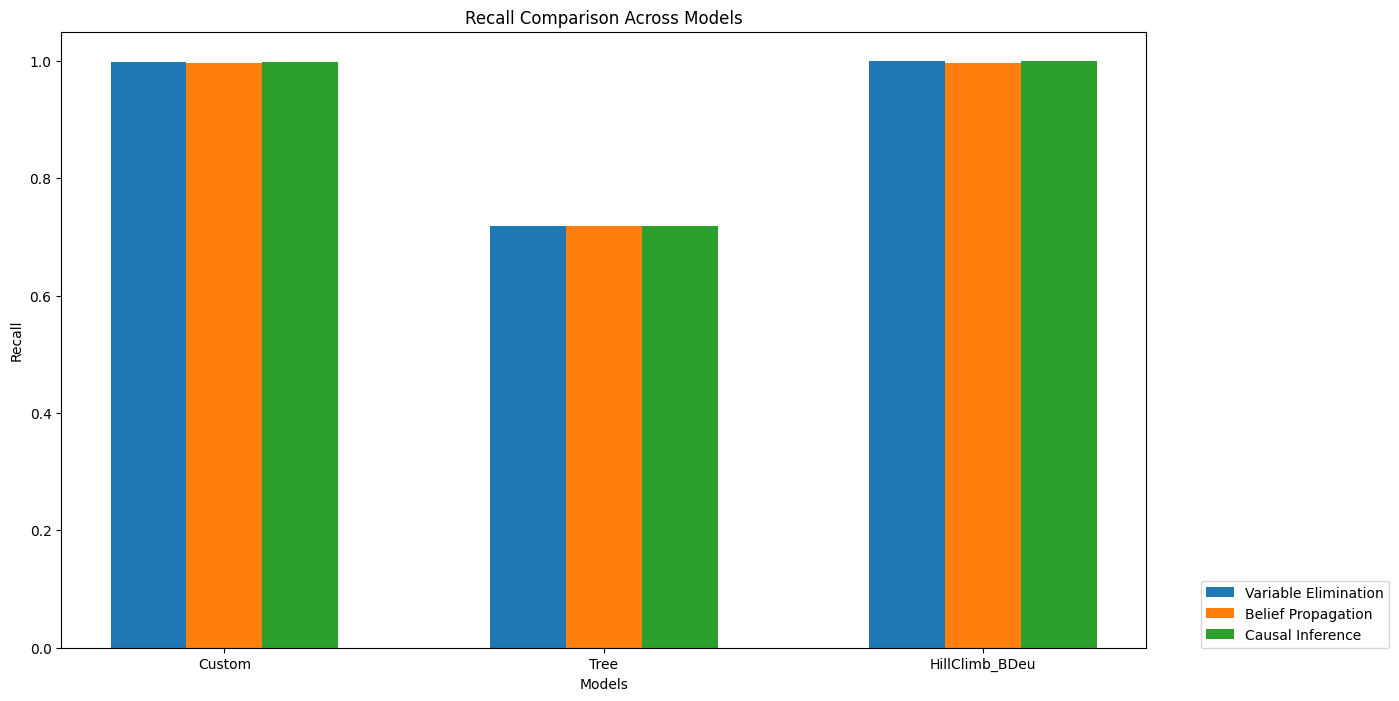

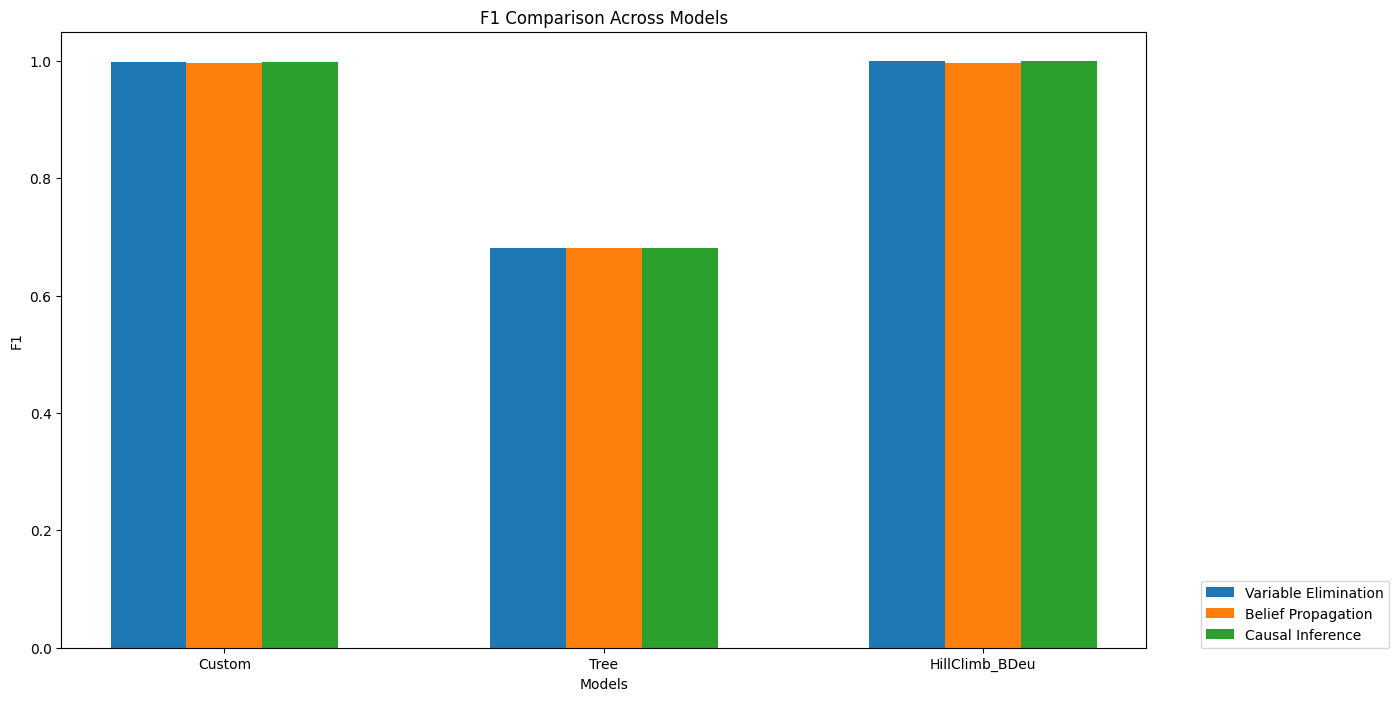

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Supponiamo che testing sia un dizionario contenente i risultati dei test per ciascun modello
# con chiavi come 'modello_1', 'modello_2', ecc.

# Crea un DataFrame dai risultati
results_df = pd.DataFrame(testing).transpose()

# Nomi dei modelli
models_names = results_df.index.tolist()

# Metrice da visualizzare (ad esempio, accuracy, precision, recall, f1)
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']

# Creazione dei grafici
for metric in metrics_to_plot:
    plt.figure(figsize=(14, 8))
    
    # Lista per contenere i valori di ciascun tipo di inferenza
    values_variable_elimination = []
    values_belief_propagation = []
    values_causal_inference = []

    for model_name in models_names:
        values_variable_elimination.append(results_df[metric][model_name]['variable_elimination'])
        values_belief_propagation.append(results_df[metric][model_name]['belief_propagation'])
        values_causal_inference.append(results_df[metric][model_name]['causal_inference'])

    # Create a bar for each inference type
    x_ticks = np.arange(len(models_names))
    width = 0.2  # width of the bars

    plt.bar(x_ticks - width, values_variable_elimination, width, label='Variable Elimination')
    plt.bar(x_ticks, values_belief_propagation, width, label='Belief Propagation')
    plt.bar(x_ticks + width, values_causal_inference, width, label='Causal Inference')

    plt.title(f'{metric.capitalize()} Comparison Across Models')
    plt.xlabel('Models')
    plt.ylabel(metric.capitalize())
    plt.xticks(x_ticks, models_names)

    # Imposta la posizione della legenda in basso a destra (puoi regolare le coordinate in base alle tue esigenze)
    plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    
    plt.show()


In [61]:
# e = experiment(query=['Level'], evidence={
#     'Smoking' : 7, 
#     'Alcohol use' : 7,
#     }, models=models)


### Query 1

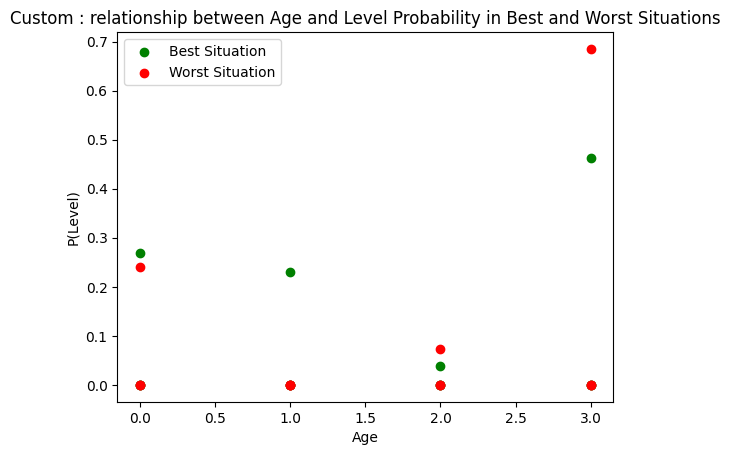

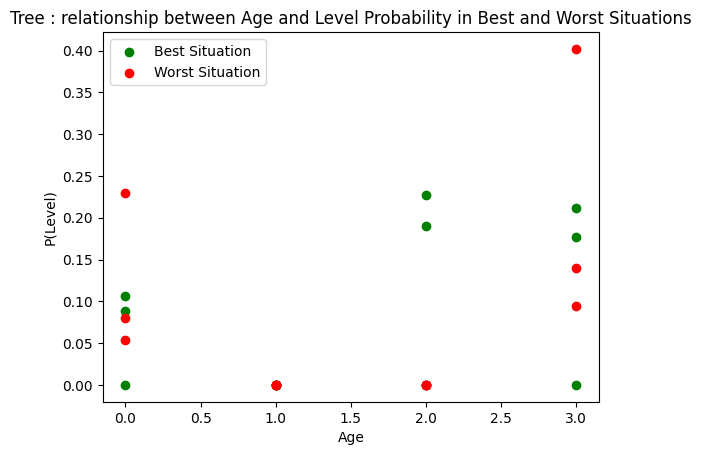

/usr/local/lib/python3.12/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:491: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


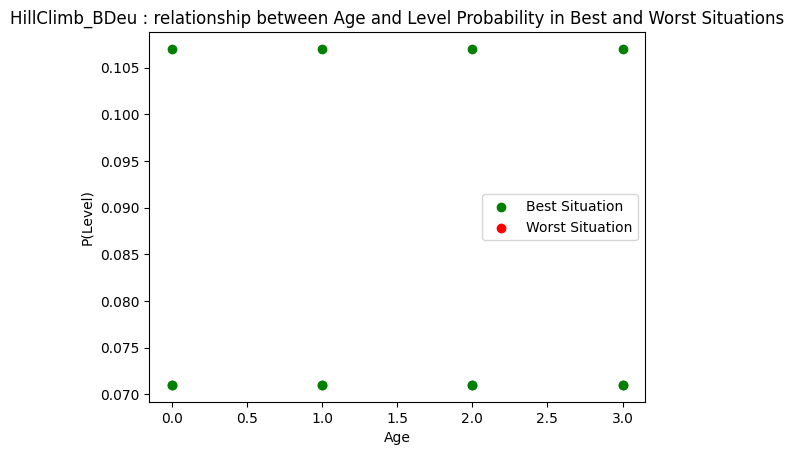

In [62]:
for m in models.keys() :
    # Age (Best situation vs Worst_situations) over the Level of the cancer
    best_situa = exact_inference(query=['Level','Age'], evidence={
        'Air Pollution': 0,
        'Alcohol use': 0,
        'Genetic Risk': 0,
        'Chronic Lung Disease': 0,
        'Smoking': 0,
        'Chest Pain': 0,
        'Coughing of Blood': 0
    }, model=models[m])

    worst_situa = exact_inference(query=['Level','Age'], evidence={
        'Air Pollution': 7,
        'Alcohol use': 7,
        'Genetic Risk': 6,
        'Chronic Lung Disease': 6,
        'Smoking': 7,
        'Chest Pain': 8,
        'Coughing of Blood': 8
    }, model=models[m])

    # Scatter plot for best situation
    plt.scatter(best_situa['Age'], best_situa['P(Level, Age)'], label='Best Situation', color='green')

    # Scatter plot for worst situation
    plt.scatter(worst_situa['Age'], worst_situa['P(Level, Age)'], label='Worst Situation', color='red')

    # Set labels and title
    plt.xlabel('Age')
    plt.ylabel('P(Level)')
    plt.title(f'{m} : relationship between Age and Level Probability in Best and Worst Situations')

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()

In [63]:
e['Custom']['approximatives']

NameError: name 'e' is not defined

In [ ]:
result = pd.merge(best_situa, worst_situa, on=['Level', 'Age'], suffixes=('_best', '_worst'))
result

In [ ]:
# Scatter plot for best situation
plt.scatter(best_situa['Age'], best_situa['P(Level, Age)'], label='Best Situation', color='green')

# Scatter plot for worst situation
plt.scatter(worst_situa['Age'], worst_situa['P(Level, Age)'], label='Worst Situation', color='red')

# Set labels and title
plt.xlabel('Age')
plt.ylabel('P(Level)')
plt.title('Relationship between Age and Level Probability in Best and Worst Situations')

# Show legend
plt.legend()

# Show the plot
plt.show()

The data we obtain doesn't make much sense since we expected a much higher difference between the best situation and the worst one in each age and then the higher the diffference the higer the age.

### Query 2